# SSH-sst feedback : 

Computes sea surface height anomalies (SSHA; used as a proxy for subsurface temperature) regressed onto sea surface temperature anomalies (SSTA) both in the eastern equatorial Pacific (horizontal Niño3 average).

#### Reference observations:
TropFlux and AVISO 1993-2018 (main)

SSH: JPL-MEASURES 1993-2021, CSIRO-SSH 1993-2019, GODAS 1980-2023, ORAS5 1958-2022, SODA3.4.2 1979-2018
SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [2]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [3]:
model_ssh_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_ssh_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

#tos
model_tos = {"ACCESS-ESM1-5": 
    model_ssh_datasets["ACCESS-ESM1-5"].copy(short_name='tos')}



obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}
obs_tauu_datasets = { ##zos
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}

In [4]:
model_ssh_datasets = {name: dataset.load() for name, dataset in model_ssh_datasets.items()}
model_tos = {name: dataset.load() for name, dataset in model_tos.items()}

# obs_tos_datasets = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
# obs_tauu_datasets = {name: dataset.load() for name, dataset in obs_tauu_datasets.items()}

In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [6]:
def ssh_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = mask_landsea(cube, mask_out="land") #irregular
    cube = convert_units(cube, units="cm")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    
    # cube = area_statistics(cube,operator='mean')
    return cube


def tos_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    return cube   

In [7]:
model_ssh_prep = {name: ssh_east(dataset) for name, dataset in model_ssh_datasets.items()}
model_tos_prep = {name: tos_east(dataset) for name, dataset in model_tos.items()}

# obs_tos_prep = {name: sst_east(dataset) for name, dataset in obs_tos_datasets.items()}
# obs_tauu_prep = {name: taux_west(dataset) for name, dataset in obs_tauu_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along first dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2140: IrisVagueMetadataWarning: Collapsin

## Calculate Linear regression

In [11]:
# scp.LinReg(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data).intcpt
B_data = model_tos_prep["ACCESS-ESM1-5"].data
B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, model_ssh_prep["ACCESS-ESM1-5"].data, rcond=None)
coefs

array([8.071279e-01, 9.792932e-08], dtype=float32)

# Diagnostic Level 1

-13.743567 -3.1139278 12.071407 2.5178785
0.020124065041091148 6.964447947967143e-09
(432,) (432,)
degC cm


Text(0.02, 0.9, 'slope: 0.02 ')

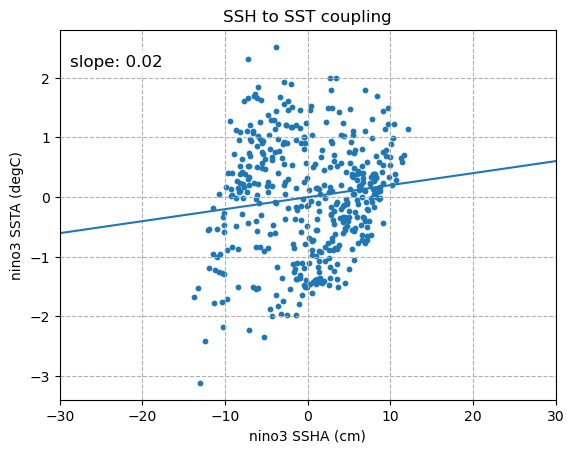

In [28]:
from scipy.stats import linregress
xseq = np.linspace(-30, 30, num=100)
print(model_ssh_prep["ACCESS-ESM1-5"].data.min(), model_tos_prep["ACCESS-ESM1-5"].data.min(), 
      model_ssh_prep["ACCESS-ESM1-5"].data.max(), model_tos_prep["ACCESS-ESM1-5"].data.max())

slope, intcpt, _,_,_ = linregress(model_ssh_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data)
plt.plot(xseq, intcpt+slope*xseq)
print(slope, intcpt)
mod_slope = slope

# slope, intcpt, _,_,_ = linregress(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data)
# plt.plot(xseq, intcpt+slope*xseq, color='black')
# metric_val = abs((mod_slope-slope)/slope)*100

print(model_tos_prep["ACCESS-ESM1-5"].shape, model_ssh_prep["ACCESS-ESM1-5"].shape) #scatter plot
print(model_tos_prep["ACCESS-ESM1-5"].units, model_ssh_prep["ACCESS-ESM1-5"].units)
plt.scatter(model_ssh_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data, s=10)

# print(obs_tos_prep["HadISST"].shape, obs_tauu_prep["ERA-Interim"].shape)
# plt.scatter(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data,s=20, c='black', marker='D')
plt.xlim(-30,30)
yunit = model_tos_prep["ACCESS-ESM1-5"].units 
xunit = model_ssh_prep["ACCESS-ESM1-5"].units

plt.title('SSH to SST coupling')
plt.ylabel(f'nino3 SSTA ({yunit})')
plt.xlabel(f'nino3 SSHA ({xunit})')
plt.grid(linestyle='--')

## text slope
plt.text(0.02, 0.9, f'slope: {mod_slope:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# print(metric_val)

# Diagnostic Level 2

(432, 2)
slope (x<0) = 0.04440729052315089
slope (x>0) = 0.10493520349435483
0.020124065041091148


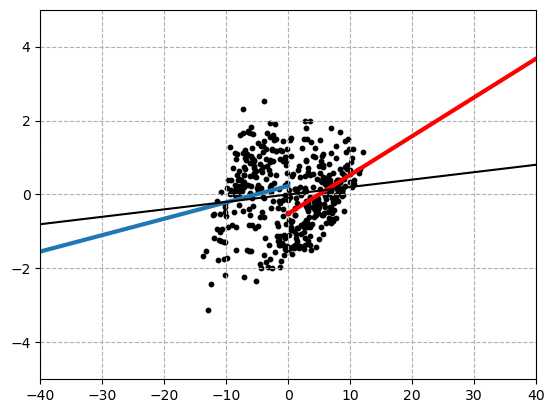

In [20]:
# SPLIT BY X<0 AND X>0 (temp)
import pandas as pd

model_tos_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"]
# matrix/cube? split by tauua 0 -df?time rows, col tauu,ssh create tuple points, zip

df = pd.DataFrame({'tos':model_tos_prep["ACCESS-ESM1-5"].data, 'ssh':model_ssh_prep["ACCESS-ESM1-5"].data})
print(df.shape)
df.loc[df['ssh']<0]

xseq = np.linspace(-50, 0, num=50)
slope, intcpt, _,_,_ = linregress(df.loc[df['ssh']<0, 'ssh'], df.loc[df['ssh']<0, 'tos'])
plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
print(f'slope (x<0) = {slope}')
xseq = np.linspace(0, 50, num=50)
slope, intcpt, _,_,_ = linregress(df.loc[df['ssh']>0, 'ssh'], df.loc[df['ssh']>0, 'tos'])
plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
print(f'slope (x>0) = {slope}')

plt.scatter(model_ssh_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data, c='k', s=10)
xseq = np.linspace(-50, 50, num=50)
slope, intcpt, _,_,_ = linregress(df['ssh'], df['tos'])
plt.plot(xseq, intcpt+slope*xseq, c='black')
print(slope)
plt.xlim(-40,40)
plt.ylim(-5,5)
plt.grid(linestyle='--')